# PSB injection bump in Xsuite - track!

In [1]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

###  Load line from previous notebook

In [3]:
# Reload
line = xt.Line.from_json('psb_05_thin.json')
line.build_tracker()
tw = line.twiss()

line.vars['t_turn_s'] = 0 # avoid leftovers from previous scripts

Loading line from dict: 100%|███| 2396/2396 [00:00<00:00, 16377.86it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [4]:
# check kinetic energy
e_kin_inj_ev = xt.PROTON_MASS_EV * (line.particle_ref.gamma0[0] - 1)
beta0_inj = line.particle_ref.beta0[0]

print(f'Kinetic energy at injection: {1e-9 * e_kin_inj_ev:.5f} GeV (beta={beta0_inj:.5f})')

Kinetic energy at injection: 0.16000 GeV (beta=0.51975)


### Enable chicane and chicane correction

In [5]:
line.vars['on_chicane_k0'] = 1
line.vars['on_chicane_k2'] = 1
line.vars['on_chicane_beta_corr'] = 1
line.vars['on_chicane_tune_corr'] = 1

### Install monitor at foil

In [6]:
num_turns = 10000

monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, particle_id_range=(0,50))

line.discard_tracker()
line.insert_element(index='bi1.tstr1l1', element=monitor, name='monitor_at_foil')
line.build_tracker()

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


### Generate some test particles

In [7]:
line.vars['t_turn_s'] = 0.
p = line.build_particles(zeta=np.linspace(-45, 45, 50))

### Enable time-dependent variables (update `t_turn_s` automatically during tracking)

In [8]:
line.enable_time_dependent_vars = True
# line.dt_update_time_dependent_vars = 3e-6
line.vars.cache_active = True
line.vars['t_turn_s'] = 0.

In [9]:
print('Tracking...')
line.track(p, num_turns=num_turns, time=True, with_progress=True)
print(f'Done in {line.time_last_track:.4} s')

Tracking...


Tracking: 100%|█████████████████| 10000/10000 [00:46<00:00, 213.93it/s]

Done in 46.75 s


<IPython.core.display.Javascript object>


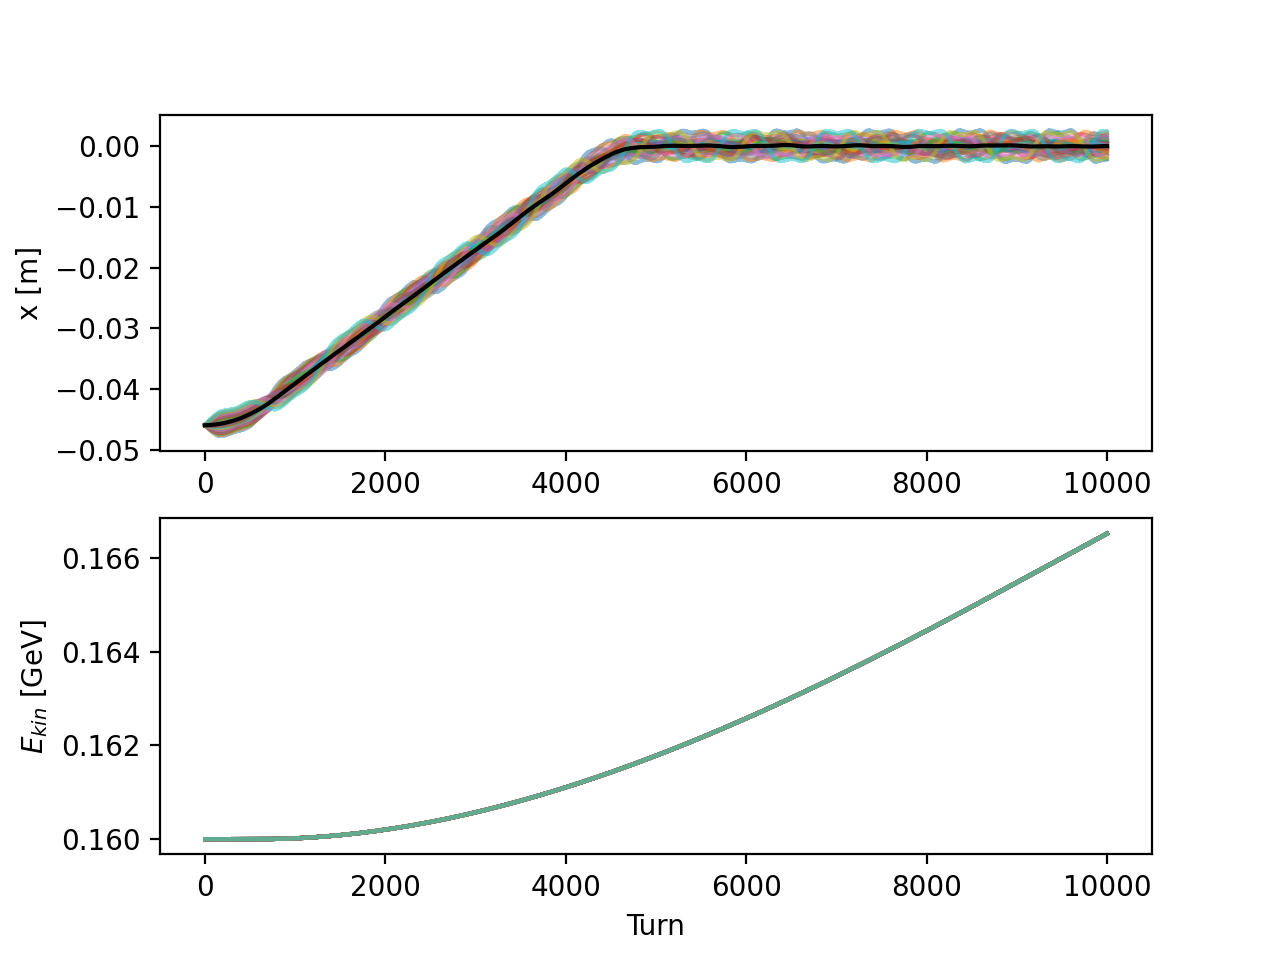

In [11]:
import matplotlib.pyplot as plt
plt.close('all')
plt.figure(1)
sp1 = plt.subplot(2,1,1)
plt.plot(monitor.x.T, alpha=0.5)
plt.plot(np.mean(monitor.x, axis=0), color='k')

plt.ylabel('x [m]')
plt.subplot(2,1,2, sharex=sp1)
plt.plot(1e-9 * xt.PROTON_MASS_EV * (monitor.gamma0.T - 1), alpha=0.5)
plt.ylabel(r'$E_{kin}$ [GeV]')
plt.xlabel('Turn')
plt.show()

<IPython.core.display.Javascript object>


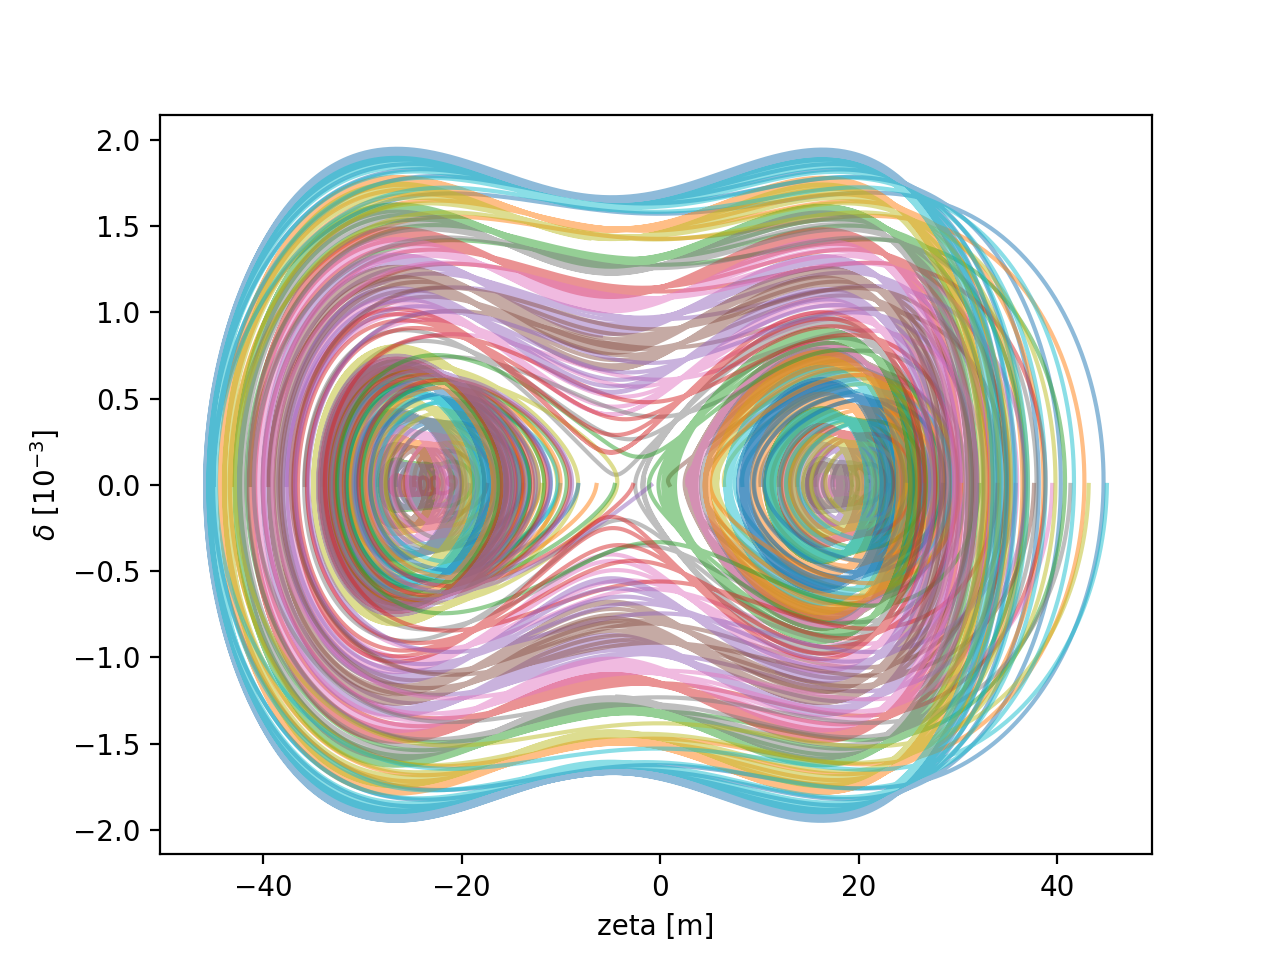

Text(0, 0.5, '$\\delta$ [$10^{-3}$]')

In [12]:
plt.figure(2)
_ = plt.plot(monitor.zeta.T, monitor.delta.T * 1e3, alpha=0.5)
plt.xlabel('zeta [m]')
plt.ylabel(r'$\delta$ [$10^{-3}$]')


### Check that revolution frequency is changing

<IPython.core.display.Javascript object>


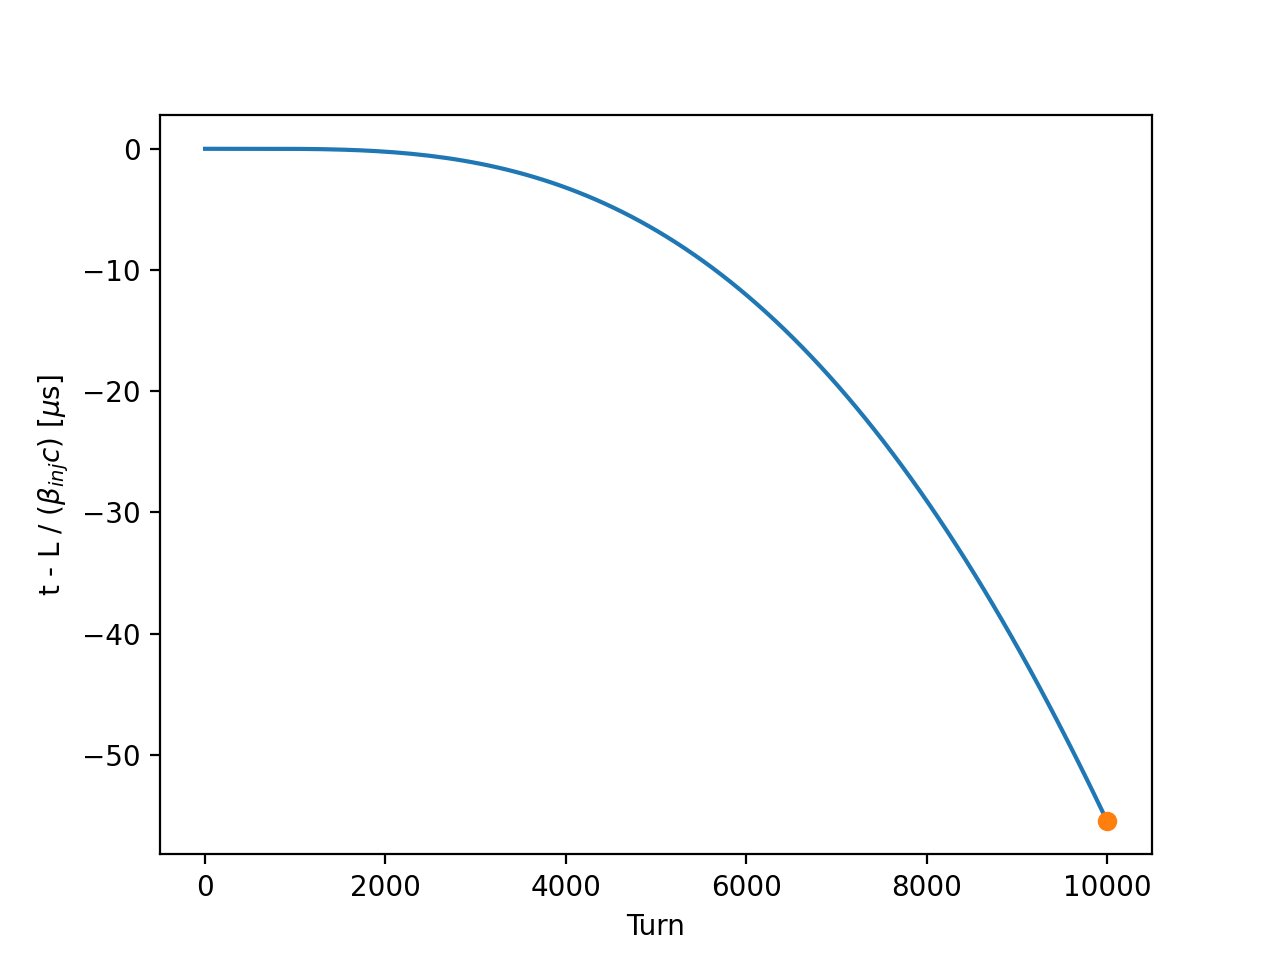

Text(0.5, 0, 'Turn')

In [13]:
from scipy.constants import c as clight

i_turn_test = np.arange(num_turns)
t_turn = line.energy_program.get_t_s_at_turn(i_turn_test)
t_turn_constant_energy = i_turn_test * line.get_length()/clight/beta0_inj

plt.figure(3)
plt.plot(i_turn_test, 1e6 * (t_turn - t_turn_constant_energy))
plt.plot(num_turns-1, 1e6 * (line.vv['t_turn_s'] - t_turn_constant_energy[-1]), 'o')

plt.ylabel(r't - L / ($\beta_{inj} c$) [$\mu$s]')
plt.xlabel('Turn')

In [ ]:
# Multiturn injection

### Load particles for multiturn injection

-------